<a href="https://colab.research.google.com/github/valenciajaime/MN2022_colabs/blob/main/Anteriores/Ajuste_RLCserie_MN2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ejemplo de ajuste de parametros en un modelo de **circuito RLC serie** a partir de datos de medidas de voltaje aplicado y corrienhte.


Uso de odeint() del modulo scipy.integrate para la solucion de la EDO.

uso de mininimize() del modulo scipy.optimize para busqueda de minimos en funciones escalares multivariadas.


Jaime A. Valencia 
jalejandro.valencia@udea.edu.co

19-Nov-2020 jueves

# Modulo y funciones
Se importan los modulos para la solucion numerica de ecuaciones diferenciales ordinarias y para minimizacion del error.
se programaran las funciones requeridas.


In [ ]:
import  matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy import optimize as OP

def RLCserie(Z, t, R = 400, L = 0.7, C = 1e-6, v = lambda x:100 ):
    """Z: funcion vectorial dependiente de t
       t: variable independiente
       Funcion para solucion del circuito
       serie RLC
       vf = R i + L di/dt + vc
       ic = C dvc/dt
       
    """
    # voltaje en voltios
    # R en ohmios
    # L en Henrios
    # C en Faradios

    vf = v(t)
     
    Is = Z[0] #corriente del circuito
    Vc = Z[1] #voltaje en condensador
    di = (1/L)*(vf - R*Is - Vc)
    dvc = (1/C)*Is
    return [di, dvc]


def ErrorEDO_01(X,t_d,y_d, v_d):
    """X=[R,L] parametros  t_d: datos tiempo
                           y_d: datos corriente
                           v_d: datos voltaje
        Calcula el error de la solucion
        con los parametros R,L,C
                            ErrorEDO_01
    """
    Io = y_d[0]#se asume esta condicion inicial
    Z0 = [Io,0]
    Rp = X[0]
    Lp = X[1]
    Cp = X[2]

    #funcion de voltaje interpolada
    v_fun = lambda t:np.interp(t,t_d,v_d)

    #solucion de  la ecuacion diferencia
    y_mod = odeint(RLCserie, Z0, t_d,(Rp,Lp,Cp,v_fun))
    y_mod1 = y_mod[:,0] #se toma solo la corriente

    #para asegurar igual dimension
    yd = np.array(y_d).reshape(y_mod1.shape)

    #calculo error cuadratico medio
    sme = np.sum((y_mod1-yd)**2)/len(t_d)

    return sme


# Paso 1. Lectura datos medidas

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Data_RLCserie.txt to Data_RLCserie.txt
User uploaded file "Data_RLCserie.txt" with length 7314 bytes


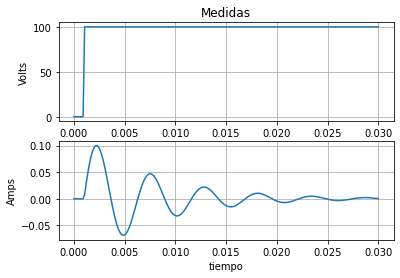

In [ ]:

fd = open("Data_RLCserie.txt",'r')

t_medida=[]
v_medida=[]
i_medida=[]

for q in fd:
    q1 = q.split(";")
    ti = float(q1[0])
    vi = float(q1[1])
    ii = float(q1[2])
    t_medida.append(ti)
    v_medida.append(vi)
    i_medida.append(ii)

plt.subplot(2,1,1)
plt.plot(t_medida,v_medida)
plt.ylabel("Volts")
plt.title("Medidas")
plt.grid('on')

plt.subplot(2,1,2)
plt.plot(t_medida,i_medida)
plt.ylabel("Amps")
plt.xlabel("tiempo")

plt.grid('on')
plt.show()


# Paso 2. Aproximacion de Parametros iniciales

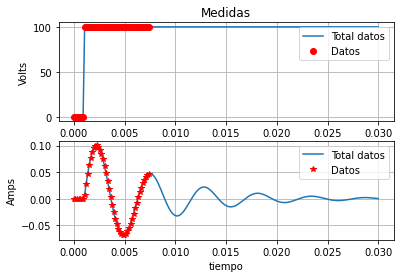

Error inicial:  0.008496371431713376


In [ ]:
P_o = [10, 0.3, 0.5e-6] #R inicial, L inicial y C inicial
Nd = 50 #numero de datos a usar

plt.subplot(2,1,1)
plt.plot(t_medida,v_medida,t_medida[:Nd],v_medida[:Nd],'ro')
plt.title("Medidas")
plt.ylabel("Volts")
plt.legend(["Total datos","Datos"])
plt.grid('on')

plt.subplot(2,1,2)
plt.plot(t_medida,i_medida,t_medida[:Nd],i_medida[:Nd],'r*')
plt.ylabel("Amps")
plt.legend(["Total datos","Datos"])
plt.grid('on')
plt.xlabel("tiempo")
plt.show()

E_ini = ErrorEDO_01(P_o,t_medida[:Nd],i_medida[:Nd], v_medida[:Nd])

print("Error inicial: ",E_ini)


# Paso 3. Minimizar error

La funcion minimize() dispone de varios algoritmos de busqueda de minimos de funciones multivariadas.

In [ ]:
Args = (t_medida[:Nd],i_medida[:Nd],v_medida[:Nd])

Res = OP.minimize(ErrorEDO_01,P_o,Args, method='Powell')


print("Aproximacion (R,L,C): ",Res.x)
print("Error cuadratico medio: ",Res.fun)


Aproximacion (R,L,C):  [1.97583704e+02 7.08830642e-01 9.98905027e-07]
Error cuadratico medio:  5.422222522297966e-07


# Paso 4. Representacion grafica resultado

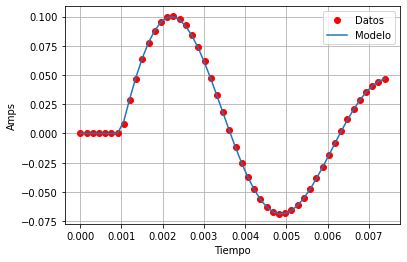

In [ ]:

R_aprox = Res.x[0]
L_aprox = Res.x[1]
C_aprox = Res.x[2]

I0 = i_medida[0]

Z0 = [I0,0.0]

V_s = lambda t:np.interp(t,t_medida[:Nd],v_medida[:Nd])

Y_sol = odeint(RLCserie, Z0, t_medida[:Nd],(R_aprox,L_aprox,C_aprox,V_s))


plt.plot(t_medida[:Nd],i_medida[:Nd],"ro")
plt.plot(t_medida[:Nd],Y_sol[:,0])
plt.legend(["Datos","Modelo"])
plt.xlabel("Tiempo")
plt.ylabel("Amps")
plt.grid('on')
plt.show()
